In [1]:
# Importing all the required Libraries
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

Using TensorFlow backend.


In [2]:
# Changing the working directory
os.chdir("E:\Data Science Challange\Cronj\dataset")

In [3]:
# Importing the dataset from the directory
train_dir = pathlib.Path()
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(180, 180),
  batch_size=32)

Found 6556 files belonging to 2 classes.


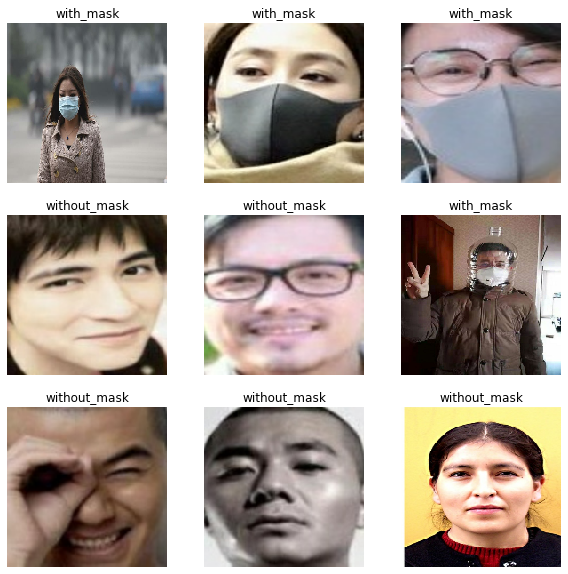

In [8]:
#Looking at few samples from the dataset by plotting them
class_names = train_ds.class_names

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
#Importing the dataset and Applying the augmentations for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip = True)

training_data =train_datagen.flow_from_directory(
    train_dir,
    target_size=(180,180),
    shuffle=True,
    batch_size=32,
    color_mode="rgb",
    subset='training',
    class_mode='binary'
    ) 

Found 3833 images belonging to 2 classes.


In [ ]:
test_data =train_datagen.flow_from_directory(
    train_dir,
    target_size=(180,180),
    batch_size=32,
    shuffle=True,
    subset='validation',
    class_mode='binary'
    ) 

# Creating CNN


In [10]:
# Creating a model 
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=16,kernel_size=3,activation ='relu',input_shape=[180,180,3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation ='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128,activation='relu'))
cnn.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

In [11]:
cnn.compile(optimizer='adam', loss = 'binary_crossentropy',metrics=['accuracy'])

In [12]:
history = cnn.fit(x=training_data,validation_data =test_data,epochs=20)

Epoch 1/20
120/120 [==============================] - 68s 564ms/step - loss: 0.4163 - accuracy: 0.8573
Epoch 2/20
120/120 [==============================] - 71s 588ms/step - loss: 0.1836 - accuracy: 0.9330
Epoch 3/20
120/120 [==============================] - 71s 589ms/step - loss: 0.1554 - accuracy: 0.9410
Epoch 4/20
120/120 [==============================] - 71s 588ms/step - loss: 0.1394 - accuracy: 0.9525
Epoch 5/20
120/120 [==============================] - 71s 591ms/step - loss: 0.1238 - accuracy: 0.9567
Epoch 6/20
120/120 [==============================] - 71s 590ms/step - loss: 0.0960 - accuracy: 0.9632
Epoch 7/20
120/120 [==============================] - 70s 587ms/step - loss: 0.1008 - accuracy: 0.9643
Epoch 8/20
120/120 [==============================] - 71s 591ms/step - loss: 0.0907 - accuracy: 0.9684
Epoch 9/20
120/120 [==============================] - 71s 593ms/step - loss: 0.0824 - accuracy: 0.9703
Epoch 10/20
120/120 [==============================] - 71s 588ms/step - l

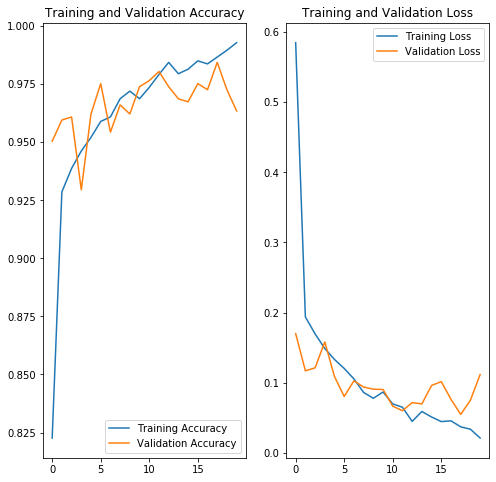

In [32]:
#Plotting the graph for accuracy vs validation accuracy and Loss vs Validation Loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
cnn.save('Mask_Detector.h5') 

# Transfer Learning

In [21]:
#Importing the MobileNetV2 Pre Trained model for our transfer learning
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [22]:
#Defining the image size as MobileNetV2 input size 
image_size = [160,160]

In [23]:
#Creating an object of model with predefined weights and discarding the output layer
mobnet = MobileNetV2( input_shape = image_size+[3], weights='imagenet',include_top=False)

In [24]:
#Setting the layers to untrainable as they are pre trained
for layer in mobnet.layers:
    layer.trainable= False

In [25]:
#Creating the last layers for the model
last_layer =tf.keras.layers.Flatten()(mobnet.output)

In [26]:
#Creating output layer for the model
output_layer = tf.keras.layers.Dense(units=1,activation='sigmoid')(last_layer)

In [27]:
#Final model with MobentV2 layer and  Output layer which is defined by us
model = tf.keras.Model(inputs= mobnet.input, outputs=output_layer)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________________

In [28]:
#Compiling the model
model.compile(optimizer='adam', loss = 'binary_crossentropy',metrics=['accuracy'])

In [31]:
#Importing the dataset with Augmentation and New image size for training set
train_dir = pathlib.Path()
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2,
    horizontal_flip = True)

training_data =train_datagen.flow_from_directory(
    train_dir,
    target_size=(160,160),
    batch_size=32,
    class_mode='binary',
    subset='training',
    color_mode="rgb"
    ) 

Found 5438 images belonging to 2 classes.


In [32]:
test_data =train_datagen.flow_from_directory(
    train_dir,
    target_size=(160,160),
    batch_size=32,
    shuffle=True,
    subset='validation',
    class_mode='binary',
    color_mode="rgb"
    ) 

Found 1359 images belonging to 2 classes.


In [33]:
#Training the Model for 20 epochs
history_transfer = model.fit(x=training_data,validation_data=test_data,epochs=20)

Epoch 1/20
170/170 [==============================] - 111s 654ms/step - loss: 0.1426 - accuracy: 0.9627 - val_loss: 0.0306 - val_accuracy: 0.9926
Epoch 2/20
170/170 [==============================] - 99s 584ms/step - loss: 0.0425 - accuracy: 0.9899 - val_loss: 0.0599 - val_accuracy: 0.9868
Epoch 3/20
170/170 [==============================] - 100s 587ms/step - loss: 0.0320 - accuracy: 0.9923 - val_loss: 0.0829 - val_accuracy: 0.9838
Epoch 4/20
170/170 [==============================] - 101s 592ms/step - loss: 0.0341 - accuracy: 0.9934 - val_loss: 0.0661 - val_accuracy: 0.9838
Epoch 5/20
170/170 [==============================] - 103s 604ms/step - loss: 0.0381 - accuracy: 0.9914 - val_loss: 0.1013 - val_accuracy: 0.9868
Epoch 6/20
170/170 [==============================] - 103s 609ms/step - loss: 0.0385 - accuracy: 0.9936 - val_loss: 0.0578 - val_accuracy: 0.9912
Epoch 7/20
170/170 [==============================] - 103s 606ms/step - loss: 0.0229 - accuracy: 0.9961 - val_loss: 0.3015 - 

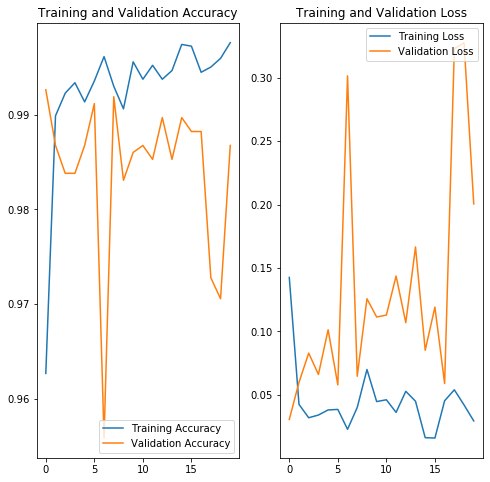

In [34]:
#Plotting the graph for accuracy vs validation accuracy and Loss vs Validation Loss

acc = history_transfer.history['accuracy']
val_acc = history_transfer.history['val_accuracy']

loss = history_transfer.history['loss']
val_loss = history_transfer.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
model.save("Transfer_LearningDetector.h5")